In [1]:
from crypto_volatility_lab.data_construction import CryptoScraper, TimeSeriesCreator
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
crypto_scraper = CryptoScraper(start_date="2024-01-01")
bitcoin_data = crypto_scraper.get_data_for_currency('BTC-USD')

In [3]:
print(bitcoin_data.shape)
bitcoin_data.tail()

(356, 7)


,Date,Open,High,Low,Close,Adj,Volume
351,"Jan 4, 2024","42,855.82","44,770.02","42,675.18","44,179.92","44,179.92","30,448,091,210"
352,"Jan 3, 2024","44,961.60","45,503.24","40,813.54","42,848.18","42,848.18","46,342,323,118"
353,"Jan 2, 2024","44,187.14","45,899.71","44,176.95","44,957.97","44,957.97","39,335,274,536"
354,"Jan 1, 2024","42,280.23","44,175.44","42,214.98","44,167.33","44,167.33","18,426,978,443"
355,"Dec 31, 2023","42,152.10","42,860.94","41,998.25","42,265.19","42,265.19","16,397,498,810"


In [4]:
ts_creator = TimeSeriesCreator(data=bitcoin_data, date_column_name='Date', value_column_name='Close')
log_returns = ts_creator.create_log_return_time_series()
volatility = ts_creator.create_volatility_time_series()

bitcoin_data["Log Returns"] = log_returns
# retransform log returns to normal returns
bitcoin_data["Returns"] = bitcoin_data["Log Returns"].apply(lambda x: 2.71828**x - 1)
bitcoin_data["Volatility"] = volatility

bitcoin_data.tail()

,Date,Open,High,Low,Close,Adj,Volume,Log Returns,Returns,Volatility
4,2024-12-16,"104,293.58","107,780.58","103,322.98",106029.72,"106,029.72","91,020,417,816",0.016461,0.016597,0.021809
3,2024-12-17,"106,030.69","108,268.45","105,291.73",106140.60,"106,140.60","68,589,364,868",0.001045,0.001046,0.021445
2,2024-12-18,"106,147.30","106,470.61","100,041.54",100041.54,"100,041.54","93,865,656,139",-0.059179,-0.057462,0.024291
1,2024-12-19,"100,070.69","102,748.15","95,587.68",97490.95,"97,490.95","97,221,662,392",-0.025826,-0.025495,0.025023
0,2024-12-20,"97,484.70","98,098.91","92,175.18",97755.93,"97,755.93","105,634,083,408",0.002714,0.002718,0.024694


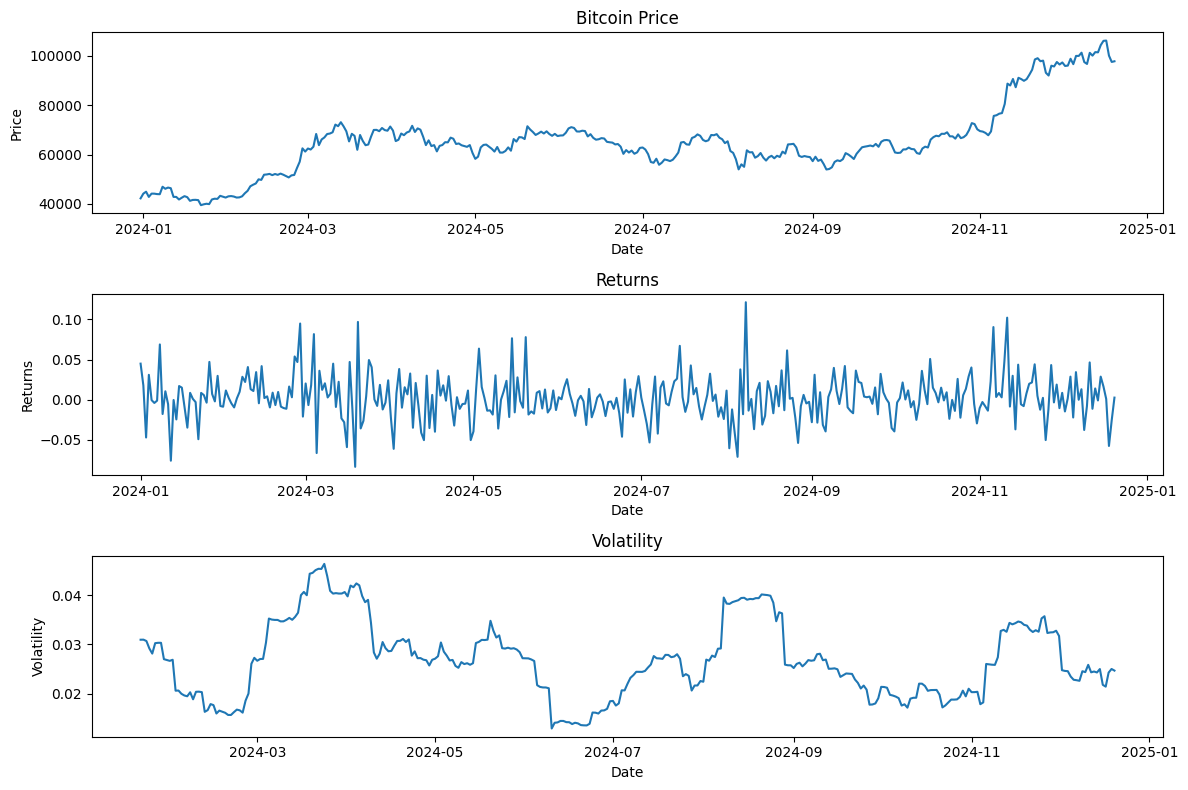

In [5]:
# sort the data by descending date
bitcoin_data = bitcoin_data.sort_values(by="Date", ascending=True)

# plotting time series by date
fig, ax = plt.subplots(3, 1, figsize=(12, 8))

ax[0].plot(bitcoin_data["Date"], bitcoin_data["Close"])
ax[0].set_title("Bitcoin Price")
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Price")

ax[1].plot(bitcoin_data["Date"], bitcoin_data["Returns"])
ax[1].set_title("Returns")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Returns")

ax[2].plot(bitcoin_data["Date"], bitcoin_data["Volatility"])
ax[2].set_title("Volatility")
ax[2].set_xlabel("Date")
ax[2].set_ylabel("Volatility")

plt.tight_layout()
plt.show()